Self-Attention
======================

In this notebook, we look at how self-attention works. In other words, no RNN, but simply self attention of source sequence for the encoder, attention (both self and cross) of the **shifted target sequence** for the decoder. 

![Self Attention](../images/encdec_self_simplified.png)

## Download Untility Files for Plotting and Data Generation

Download these utility functions first and place them in the same directory as this notebook. These files are the same as the ones in [Lab11 Sequence to Sequence Model](https://weiliu2k.github.io/CITS4012/LSTM/seq2seq.html).

In [34]:
from IPython.display import FileLink, FileLinks

In [35]:
FileLink('plots.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\plots.py

In [36]:
FileLink('plots_seq2seq.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\plots_seq2seq.py

In [37]:
FileLink('util.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\util.py

In [38]:
FileLink('replay.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\attention\replay.py

## Imports

In [39]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from util import StepByStep
from plots import *
from plots_seq2seq import *

## Data Generation

We still make use of the Square Sequences, using the first two corners to predict the last two. Same method as before for generating noisy squares. 

In [40]:
def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

## Multi-Headed Attention

In [41]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # Affine transformations for Q, K, and V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        # Linear transf. to go back to original dimension
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

## Self-Attention

Instead of using RNN to generate the hidden states, we use attention mechanism to generate hidden states for inputs. This is called self-attention, i.e. attention on the input data points themselves. Each input will have its own context vector. All context vectors are concatenated and transformed through a linear layer, as an input to the feedforward network as hidden state for the corresponding input. 

### Attention Scores from Input

Inputs or their affine transformations are used as Keys, Values and Queries. 

$$
\alpha_{\color{blue}{0}\color{red}0}, \alpha_{{\color{blue}{0}\color{red}1}} = softmax(\frac{\color{red}{Q_0}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_0}\color{black}\cdot K_1}{\sqrt{2}})
\\
\color{blue}{context\ vector_0}\color{black}= \alpha_{\color{blue}{0}\color{red}0}V_0 + \alpha_{{\color{blue}{0}\color{red}1}}V_1
$$

$$
\alpha_{\color{blue}{1}\color{red}0}, \alpha_{{\color{blue}{1}\color{red}1}} = softmax(\frac{\color{red}{Q_1}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}})
\\
\color{blue}{context\ vector_1}\color{black}= \alpha_{\color{blue}{1}\color{red}0}V_0 + \alpha_{{\color{blue}{1}\color{red}1}}V_1
$$

$$
\begin{array}{c|cc}
& source\\
target& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{blue}{h_0} & \alpha_{\color{blue}{0}\color{red}0} & \alpha_{{\color{blue}{0}\color{red}1}} \\
 \color{blue}{h_1} & \alpha_{\color{blue}{1}\color{red}0} & \alpha_{{\color{blue}{1}\color{red}1}}
\end{array}
$$

![](images/transf_encself.png)

### Encoder with Self-Attention

As you can see from the code below, each input has its own attention head, so it makes use of the multi-headed attention above. Check the code against the diagram for better understanding.

In [43]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

### Encoder the Square Sequence

The perfect sequare with four corners, is split into a source sequence of two corners and a target sequence of two corners.

In [44]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [45]:
torch.manual_seed(11)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
query = source_seq
encoder_states = encself(query)
encoder_states

tensor([[[-0.0498,  0.2193],
         [-0.0642,  0.2258]]], grad_fn=<AddBackward0>)

### Decoder

This decoder has both self attention and cross-attention, which uses the decoder hidden state as query. 

In [46]:
class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )
        
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

#### Subsequent Inputs and Teacher Forcing

The **shifted target sequence** containes the last element of the source sequence, and everything but the last element of the target sequence. 

In [47]:
shifted_seq = torch.cat([source_seq[:, -1:], target_seq[:, :-1]], dim=1)

#### Attention Scores

Because we feed the entire shifted target sequence to the decoder, we need to be careful not to allow the model to peek into the future. 

The attention score $\alpha_{22}$ is problematic, because we are using the $K_2$ and $V_2$ which the model should not have seen yet for calculation. So we need **target mask** to ensure that it is not computed.  

$$
\alpha_{\color{green}{2}\color{red}1}, \alpha_{{\color{green}{2}\color{red}2}} = softmax(\frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_2}{\sqrt{2}})
\\
\color{green}{context\ vector_2}\color{black}= \alpha_{\color{green}{2}\color{red}1}V_1 + \alpha_{{\color{green}{2}\color{red}2}}V_2
$$

Below, it is fine for us to use $K_2$ and $V_2$ to caluate $\alpha_3$.

$$
\alpha_{\color{green}{3}\color{red}1}, \alpha_{{\color{green}{3}\color{red}2}} = softmax(\frac{\color{red}{Q_2}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_2}\color{black}\cdot K_2}{\sqrt{2}})
\\
\color{green}{context\ vector_3}\color{black}= \alpha_{\color{green}{3}\color{red}1}V_1 + \alpha_{{\color{green}{3}\color{red}2}}V_2
$$

Any values in the attention score matrix that are above the diagnal line needs to be masked. Here we need to mask $\alpha_{22}$ to 0.
$$
\begin{array}{c|cc}
& source\\
target& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & \alpha_{{\color{green}{2}\color{red}2}} \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

#### Target Mask (Training)

The masked scoreing matrix should look like this:

$$
\begin{array}{c|cc}
& source\\
target& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

In [48]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1)).bool()
    return subsequent_mask

In [49]:
subsequent_mask(2) # 1, L, L

tensor([[[ True, False],
         [ True,  True]]])

:::{important} Subsequent Mask
We must use this mask while querying the decoder to prevent it
from cheating. You can choose to use an additional mask to
"hide" more data from the decoder if you wish, but the
subsequent mask is a strong requirement of the self-attention
decoder.
:::

In [50]:
torch.manual_seed(13)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself.init_keys(encoder_states)

query = shifted_seq
out = decself(query, target_mask=subsequent_mask(2))

decself.self_attn_heads.alphas

tensor([[[[1.0000, 0.0000],
          [0.4011, 0.5989]]],


        [[[1.0000, 0.0000],
          [0.4264, 0.5736]]],


        [[[1.0000, 0.0000],
          [0.6304, 0.3696]]]])

#### Target Mask (Evaluation/Prediction)

The only difference between training and evaluation, concerning the target mask,
is that we'll be using larger masks as we go. The very first mask is actually trivial
since there are no elements above the diagonal:

$$
1^{st}\ Step
\begin{cases}
\begin{array}{c|cc}
target& source\\
& \color{red}{x_1} & \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1}
\end{array}
\end{cases}
$$

In evaluation/prediction time we only have the source sequence and, in our
example, we use its last element as input for the decoder:

In [51]:
inputs = source_seq[:, -1:]
trg_masks = subsequent_mask(1)
out = decself(inputs, trg_masks)
out

tensor([[[0.4132, 0.3728]]], grad_fn=<AddBackward0>)

The mask is not actually masking anything in this case, and we get a prediction for
the coordinates of $x_2$ as expected. In RNN based seq2seq models, this prediction would be used directly as the next input, but the self-attention decoder expects the full sequence as "query", so we concatenate the prediction to the previous "query".

In [52]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward>)

Now there are two data points for querying the decoder, so we adjust the mask
accordingly.

$$
2^{nd}\ Step
\begin{cases}
\begin{array}{c|cc}
target& source\\
& \color{red}{x_1} & \color{green}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{green}2}}
\end{array}
\end{cases}
$$

In [53]:
trg_masks = subsequent_mask(2)
out = decself(inputs, trg_masks)
out

tensor([[[0.4137, 0.3727],
         [0.4132, 0.3728]]], grad_fn=<AddBackward0>)

:::{important}
The mask guarantees that the predicted $x_2$ (in the first step)
won't change the predicted $x_2$ (in the second step) because
predictions are made based on past data points only
:::

The last prediction is, once again, concatenated to the previous "query".

In [54]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward>)

But, since we're actually done with the predictions (the desired target sequence has
a length of two), we simply exclude the first data point in the query (the one coming
from the source sequence) and that's the predicted target sequence

In [55]:
inputs[:, 1:]

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<SliceBackward>)

### Encoder + Decoder + Self-Attention

In [56]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

### Data Preparation

In [57]:
points, directions = generate_sequences()
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

In [58]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [59]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

### Model Configuration & Training

In [60]:
torch.manual_seed(23)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
model = EncoderDecoderSelfAttn(encself, decself, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [61]:
sbs_seq_selfattn = StepByStep(model, loss, optimizer)
sbs_seq_selfattn.set_loaders(train_loader, test_loader)
sbs_seq_selfattn.train(100)

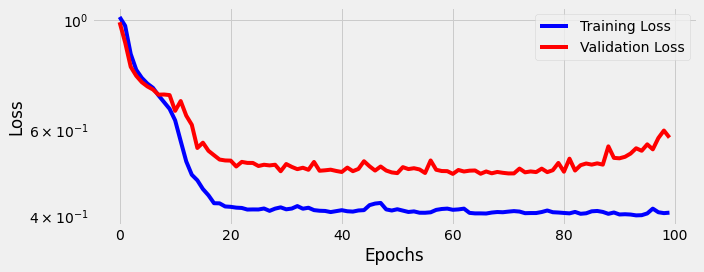

In [62]:
fig = sbs_seq_selfattn.plot_losses()

### Visualizing Predictions

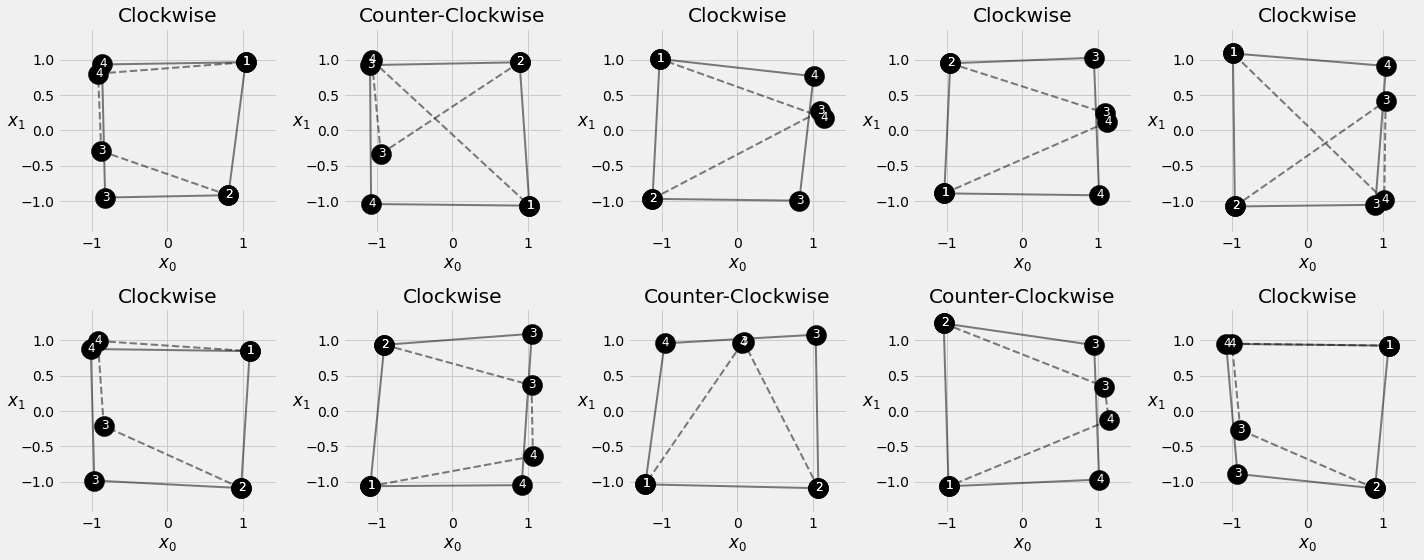

In [63]:
fig = sequence_pred(sbs_seq_selfattn, full_test, test_directions)